Data Understanding

In [126]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import tldextract
from sklearn.preprocessing import StandardScaler

Import Data

In [127]:
# Load datasets
rating_path = '../data/rating.csv'
domains_location_path = '../data/domains_location.csv'
traffic_path = '../data/traffic.csv'

rating_df = pd.read_csv(rating_path)
domains_location_df = pd.read_csv(domains_location_path)
traffic_data_df = pd.read_csv(traffic_path)

In [128]:
# Display first few rows of each dataset
print("Rating.csv:\n", tabulate(rating_df.head(), headers='keys', tablefmt='psql'))
print("\nDomains Location.csv:\n", tabulate(domains_location_df.head(), headers='keys', tablefmt='psql'))
print("\nTraffic Data.csv:\n", tabulate(traffic_data_df.head(), headers='keys', tablefmt='psql'))

Rating.csv:
 +----+--------------+-------------+----------------+----------------------------------------------------+--------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+----------------------------------------------------------------------------------------

In [129]:
# Function to print column names and shape
def print_info(df, df_name):
    print(f"{df_name} columns: {df.columns.tolist()}")
    print(f"{df_name} shape: The df has {df.shape[0]} rows and {df.shape[1]} columns.\n")

# Print information for each data set
print_info(rating_df, 'rating_df')
print_info(domains_location_df, 'domains_location_df')
print_info(traffic_data_df, 'traffic_data_df')

rating_df columns: ['article_id', 'source_id', 'source_name', 'author', 'title', 'description', 'url', 'url_to_image', 'published_at', 'content', 'category', 'article', 'title_sentiment']
rating_df shape: The df has 58356 rows and 13 columns.

domains_location_df columns: ['SourceCommonName', 'location', 'Country']
domains_location_df shape: The df has 37802 rows and 3 columns.

traffic_data_df columns: ['GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs', 'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs']
traffic_data_df shape: The df has 1000000 rows and 12 columns.



Feature Engineering

In [130]:
# Function to extract domain
def extract_domain(url):
    ext = tldextract.extract(url)
    return f"{ext.domain}.{ext.suffix}"

# Apply the function to the 'url' column
rating_df['domain'] = rating_df['url'].apply(extract_domain)

# Display the first few rows to verify
print(rating_df[['url', 'domain']].head())


                                                 url               domain
0  https://www.forbes.com/sites/elizabethbrownfie...           forbes.com
1  https://www.channelnewsasia.com/sport/nice-cla...  channelnewsasia.com
2  https://time.com/6320467/amphibians-most-vulne...             time.com
3  https://phys.org/news/2023-10-image-rusty-red-...             phys.org
4  https://www.digitaltrends.com/movies/everythin...    digitaltrends.com


In [131]:
# Get unique counts of domains
unique_rating_domains = rating_df['domain'].nunique()
unique_location_domains = domains_location_df['SourceCommonName'].nunique()
unique_traffic_domains = traffic_data_df['Domain'].nunique()

print(f"Unique domains in rating_df: {unique_rating_domains}")
print(f"Unique domains in domains_location_df: {unique_location_domains}")
print(f"Unique domains in traffic_data_df: {unique_traffic_domains}")

Unique domains in rating_df: 30
Unique domains in domains_location_df: 37472
Unique domains in traffic_data_df: 1000000


In [132]:
# Define the mapping for sentiment values
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}

# Apply the mapping to the title_sentiment column
rating_df['title_sentiment_score'] = rating_df['title_sentiment'].map(sentiment_mapping)

# Verify the changes
print(rating_df[['title_sentiment', 'title_sentiment_score']].head())


  title_sentiment  title_sentiment_score
0         Neutral                      0
1        Positive                      1
2        Negative                     -1
3         Neutral                      0
4         Neutral                      0


In [133]:
# Merge rating_df with domains_location_df
merged_df = pd.merge(rating_df, domains_location_df, left_on='domain', right_on='SourceCommonName', how='left')

# Merge the resulting DataFrame with traffic_data_df
final_df = pd.merge(merged_df, traffic_data_df, left_on='domain', right_on='Domain', how='left')

# Display the first few rows to verify
print(final_df.head())

   article_id source_id     source_name  \
0       81664       NaN          Forbes   
1       81667       NaN             CNA   
2       81694      time            Time   
3       81695       NaN        Phys.Org   
4       81703       NaN  Digital Trends   

                                              author  \
0  Elizabeth Brownfield, Contributor, \n Elizabet...   
1                                                NaN   
2                              Christina Larson / AP   
3                                       Sara Schmidt   
4                                       Jason Struss   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open

In [134]:
# Function to print column names and shape
def print_info(df, df_name):
    print(f"{df_name} columns: {df.columns.tolist()}")
    print(f"{df_name} shape: The df has {df.shape[0]} rows and {df.shape[1]} columns.\n")

# Print information for the data set
print_info(final_df, 'final_df')

final_df columns: ['article_id', 'source_id', 'source_name', 'author', 'title', 'description', 'url', 'url_to_image', 'published_at', 'content', 'category', 'article', 'title_sentiment', 'domain', 'title_sentiment_score', 'SourceCommonName', 'location', 'Country', 'GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets', 'RefIPs', 'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs']
final_df shape: The df has 58356 rows and 30 columns.



Data Preparation

In [135]:
# Function to check for missing values
def check_missing_values(df):
    total_rows = len(df)
    missing_info = df.isnull().sum()
    for column, missing_count in missing_info.items():
        if missing_count > 0:
            missing_percentage = (missing_count / total_rows) * 100
            print(f"The {column} column has {missing_count} missing values which is {missing_percentage:.2f}% of the column.")

check_missing_values(final_df)

The source_id column has 40585 missing values which is 69.55% of the column.
The author column has 2163 missing values which is 3.71% of the column.
The description column has 10 missing values which is 0.02% of the column.
The url_to_image column has 3451 missing values which is 5.91% of the column.
The category column has 21 missing values which is 0.04% of the column.
The SourceCommonName column has 1686 missing values which is 2.89% of the column.
The location column has 1686 missing values which is 2.89% of the column.
The Country column has 1686 missing values which is 2.89% of the column.


Handle Missing Values

In [136]:
# Drop source_id column
if 'source_id' in final_df.columns:
    final_df = final_df.drop(columns=['source_id'])

# Impute missing values
fill_values = {
    'author': 'Unknown',
    'description': 'No description available',
    'url_to_image': 'No image available',
    'category': 'Uncategorized',
    'SourceCommonName': 'Unknown',
    'location': 'Unknown',
    'Country': 'Unknown'
}

final_df.fillna(value=fill_values, inplace=True)

# Verify that there are no missing values
check_missing_values(final_df)

In [137]:
# Summary statistics and data types
print("\nfinal_df summary:")
print(final_df.describe(include='all'))
print("\nfinal_df data types:")
print(final_df.dtypes)


final_df summary:
           article_id     source_name           author               title  \
count    58356.000000           58356            58356               58356   
unique            NaN              29             7554               53454   
top               NaN  ETF Daily News  MarketBeat News  Morning news brief   
freq              NaN           16746            16742                  12   
mean    298958.734492             NaN              NaN                 NaN   
std     216023.477569             NaN              NaN                 NaN   
min        418.000000             NaN              NaN                 NaN   
25%     121776.500000             NaN              NaN                 NaN   
50%     251651.000000             NaN              NaN                 NaN   
75%     451541.500000             NaN              NaN                 NaN   
max     781308.000000             NaN              NaN                 NaN   

           description                      

Dropping Irrelevant Columns and Feature Engineering

In [138]:
# Convert 'published_at' to datetime with explicit format
final_df['published_at'] = pd.to_datetime(final_df['published_at'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

# Extract date-related features
final_df['published_year'] = final_df['published_at'].dt.year
final_df['published_month'] = final_df['published_at'].dt.month
final_df['published_day'] = final_df['published_at'].dt.day

# Check for NaT values in the 'published_at' column
print(final_df['published_at'].isna().sum())


42673


In [139]:
# Check for missing values
print(check_missing_values(final_df))

The published_at column has 42673 missing values which is 73.13% of the column.
The published_year column has 42673 missing values which is 73.13% of the column.
The published_month column has 42673 missing values which is 73.13% of the column.
The published_day column has 42673 missing values which is 73.13% of the column.
None


In [140]:
columns_to_drop = [
    #'article_id', 'source_name', 'url_to_image', 'article', 
    #'TLD', 'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 
    #'PrevTldRank', 'PrevRefSubNets', 'PrevRefIPs', 
    'published_at',
    'published_year', 'published_month', 'published_day'
]

columns_to_drop = [col for col in columns_to_drop if col in final_df.columns]

final_df = final_df.drop(columns=columns_to_drop)

print(check_missing_values(final_df))

# Verify the changes
print(final_df.columns)

None
Index(['article_id', 'source_name', 'author', 'title', 'description', 'url',
       'url_to_image', 'content', 'category', 'article', 'title_sentiment',
       'domain', 'title_sentiment_score', 'SourceCommonName', 'location',
       'Country', 'GlobalRank', 'TldRank', 'Domain', 'TLD', 'RefSubNets',
       'RefIPs', 'IDN_Domain', 'IDN_TLD', 'PrevGlobalRank', 'PrevTldRank',
       'PrevRefSubNets', 'PrevRefIPs'],
      dtype='object')


In [141]:
# Calculate content length
final_df['content_length'] = final_df['content'].str.len()

# Calculate title word count
final_df['title_word_count'] = final_df['title'].str.split().apply(len)

# Convert title_sentiment to numerical scores if needed
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
final_df['title_sentiment_score'] = final_df['title_sentiment'].map(sentiment_mapping)

# Display the first few rows to verify
print(final_df.head())

   article_id     source_name  \
0       81664          Forbes   
1       81667             CNA   
2       81694            Time   
3       81695        Phys.Org   
4       81703  Digital Trends   

                                              author  \
0  Elizabeth Brownfield, Contributor, \n Elizabet...   
1                                            Unknown   
2                              Christina Larson / AP   
3                                       Sara Schmidt   
4                                       Jason Struss   

                                               title  \
0  superstar chef yannick alléno brings refined f...   
1  nice claim top spot in ligue 1 with late win a...   
2  amphibians are the world’s most vulnerable spe...   
3              image: rusty red waters in madagascar   
4  everything leaving max (formerly hbo max) in n...   

                                         description  \
0  Now open in Mayfair at Four Seasons Hotel Lond...   
1  Nice moved i

Outliers

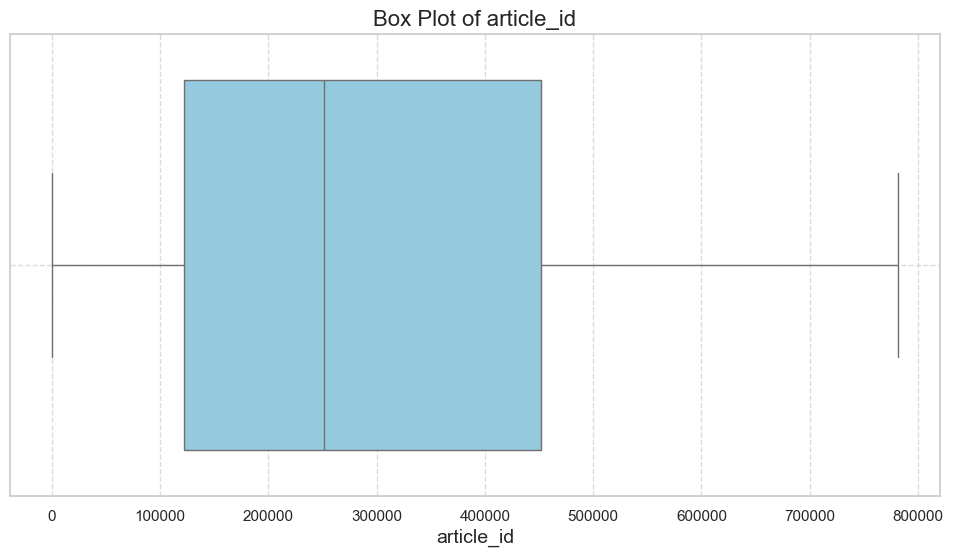

Skipping title_sentiment_score due to insufficient data for plotting.


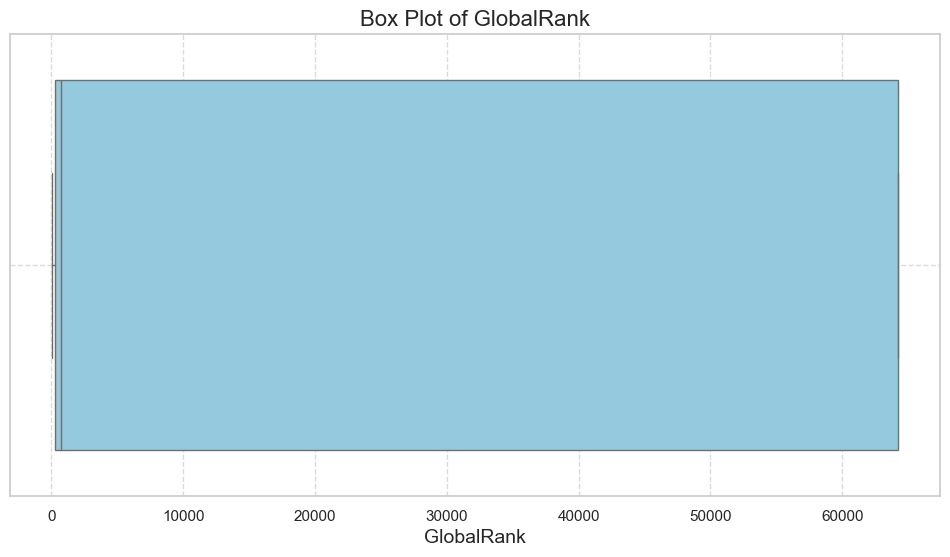

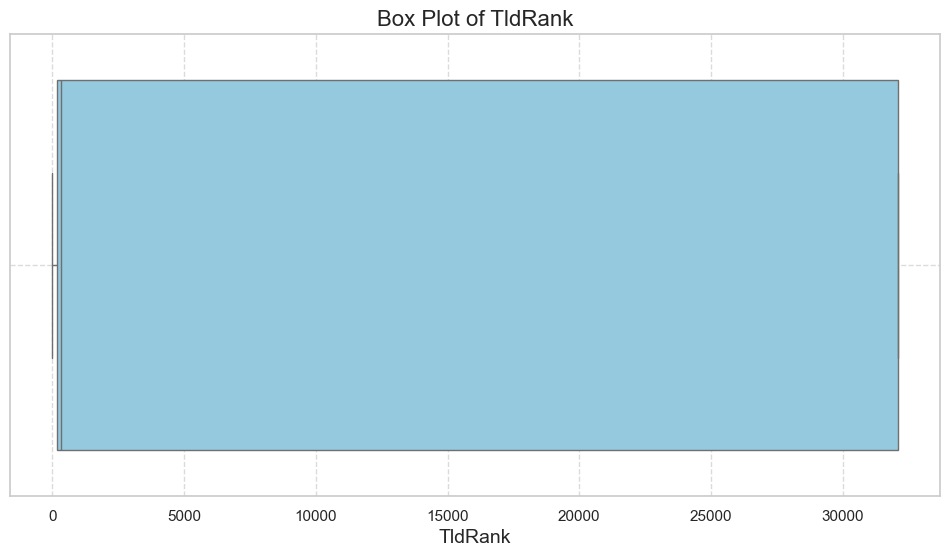

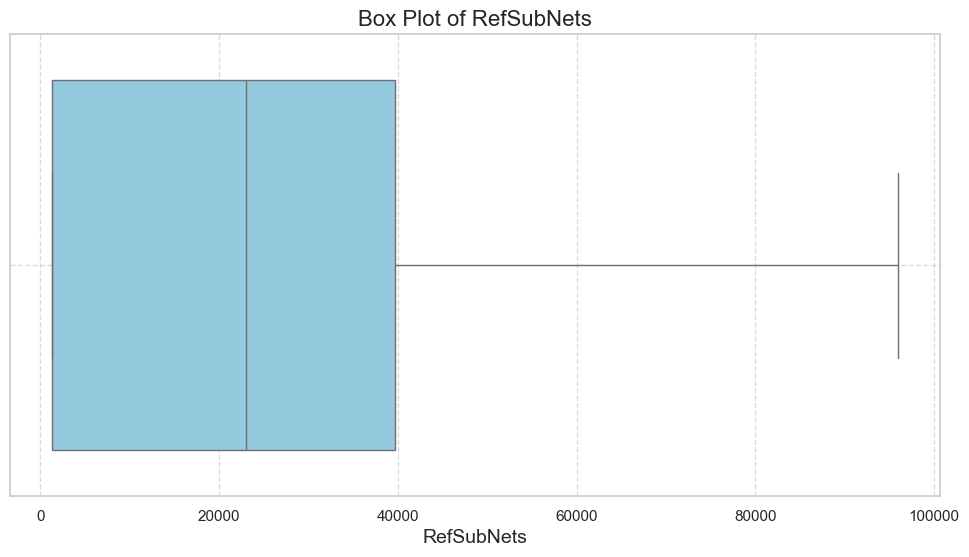

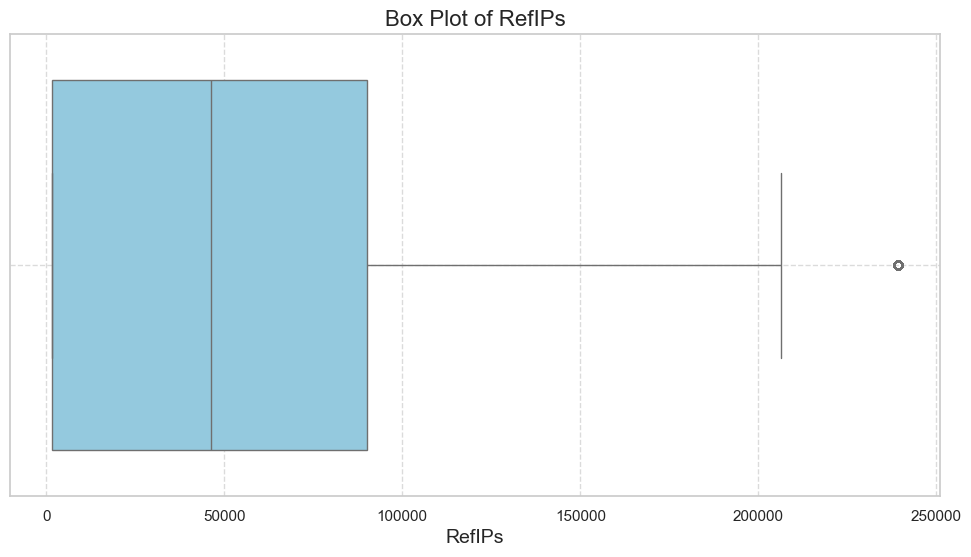

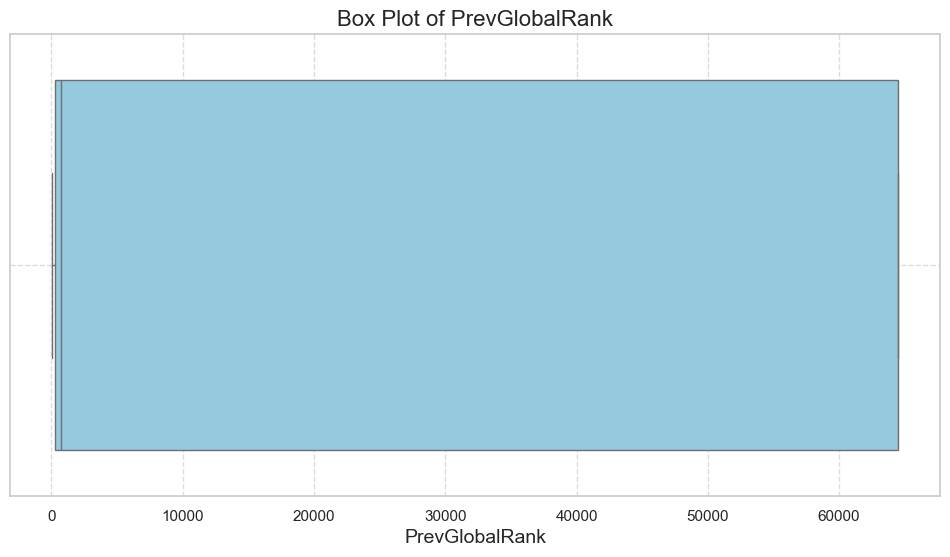

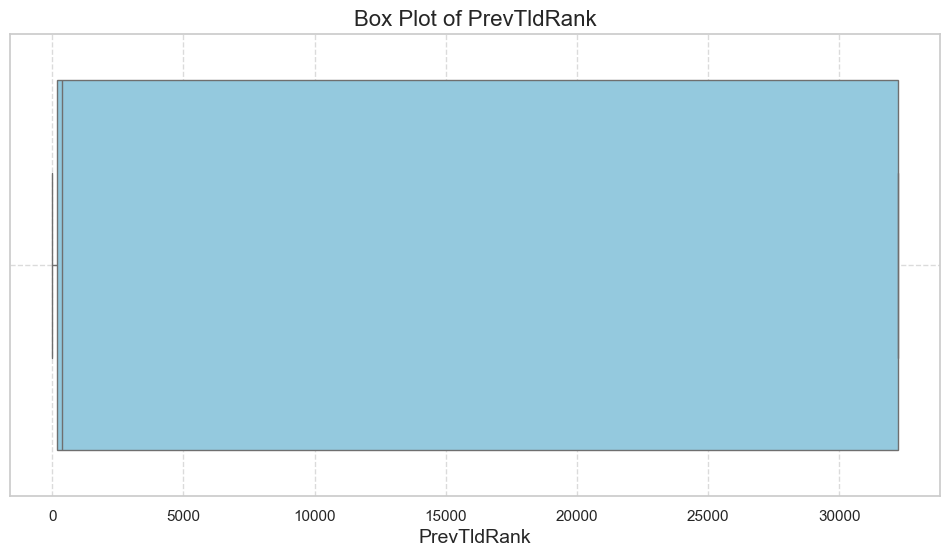

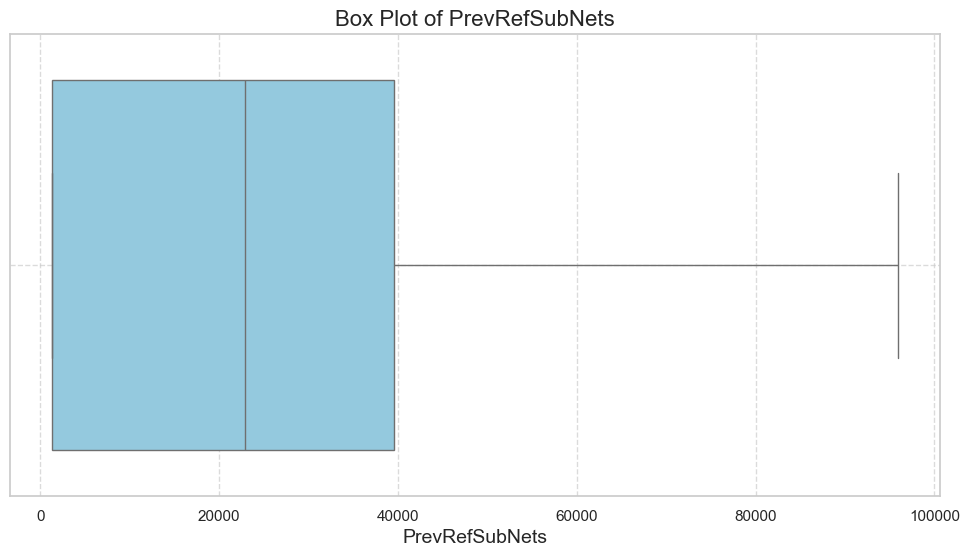

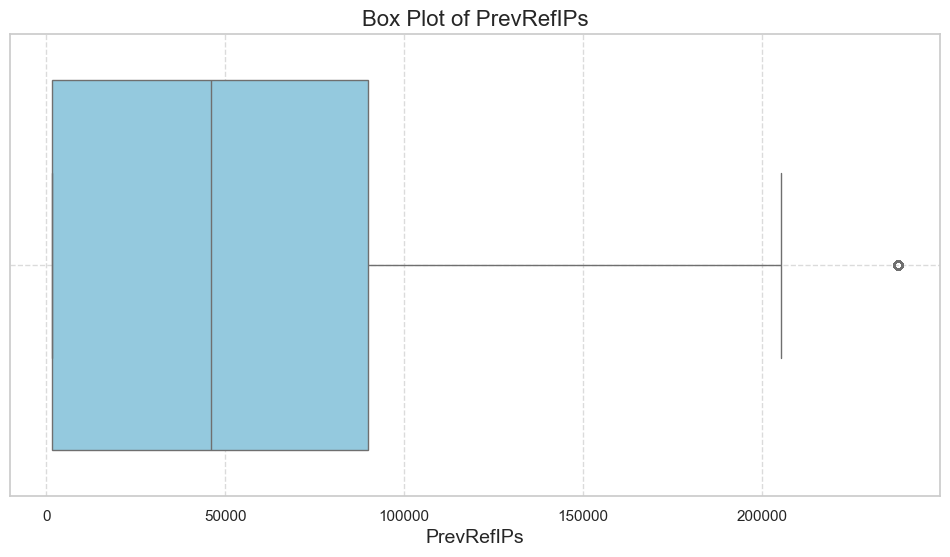

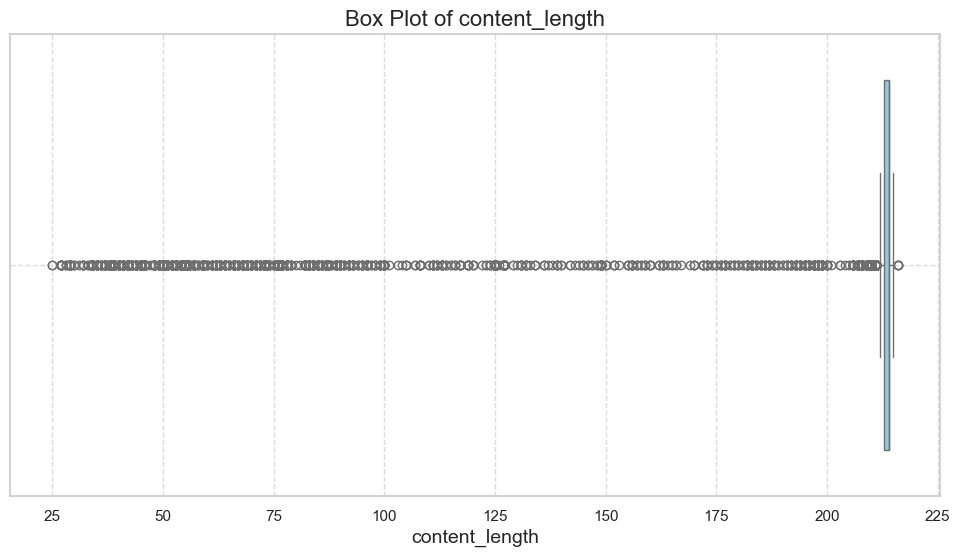

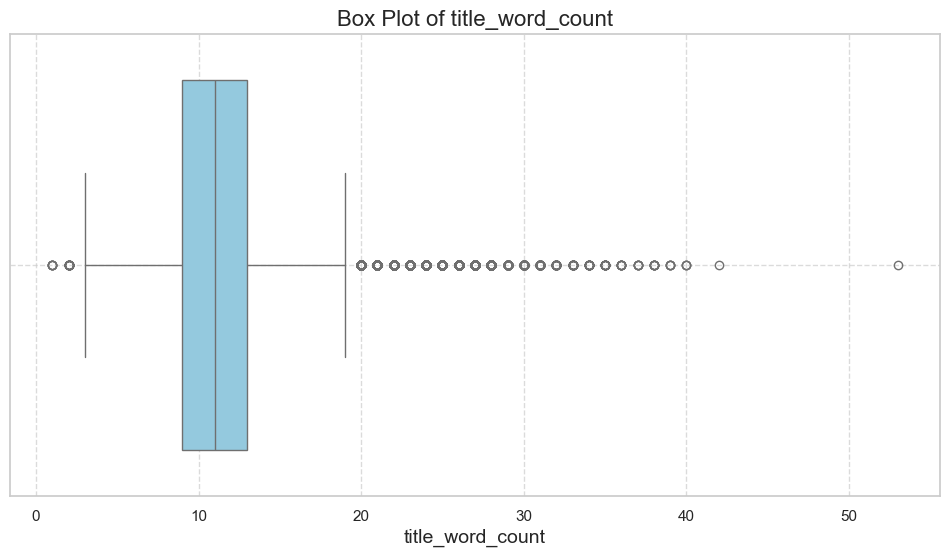

In [142]:
# Function to plot box plots for numerical columns with enhanced visuals
def plot_boxplots(df):
    # Select numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Set the overall style
    sns.set(style="whitegrid")

    for column in numerical_columns:
        # Check if the column has more than one unique value and no NaN values
        if df[column].nunique() > 1 and df[column].notna().sum() > 0:
            plt.figure(figsize=(12, 6))  # Increase figure size for better readability
            sns.boxplot(x=df[column], color='skyblue')  # Add a color for distinction
            plt.title(f'Box Plot of {column}', fontsize=16)  # Add a title with larger font size
            plt.xlabel(column, fontsize=14)  # Label the x-axis with a larger font size
            plt.grid(True, linestyle='--', alpha=0.7)  # Add gridlines for better readability
            plt.show()
        else:
            print(f"Skipping {column} due to insufficient data for plotting.")

# Call the function to plot boxplots for final_df
plot_boxplots(final_df)

In [143]:
# Function to identify outliers using Z-score
def find_outliers_zscore(df, threshold=3):
    # Select numerical columns
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    outliers_dict = {}  # Dictionary to store outliers by column
    
    for column in numerical_columns:
        # Calculate Z-scores
        z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
        
        # Identify outliers
        outliers = df[column][z_scores > threshold]
        
        # Store outliers in the dictionary
        if not outliers.empty:
            outliers_dict[column] = outliers
    
    return outliers_dict

# Call the function to find outliers for final_df
outliers = find_outliers_zscore(final_df)

# Print the outliers found
if outliers:
    for column, outlier_values in outliers.items():
        print(f"Outliers detected in column '{column}':")
        print(outlier_values)
        print("\n")
else:
    print("No outliers detected using the Z-score method.")


Outliers detected in column 'content_length':
37        62
65        65
74        51
77        71
84        38
        ... 
58227     44
58229     68
58246     91
58247    100
58269     41
Name: content_length, Length: 2016, dtype: int64


Outliers detected in column 'title_word_count':
88       26
164      28
173      25
187      29
189      26
         ..
58009    25
58066    26
58134    34
58135    35
58147    25
Name: title_word_count, Length: 950, dtype: int64




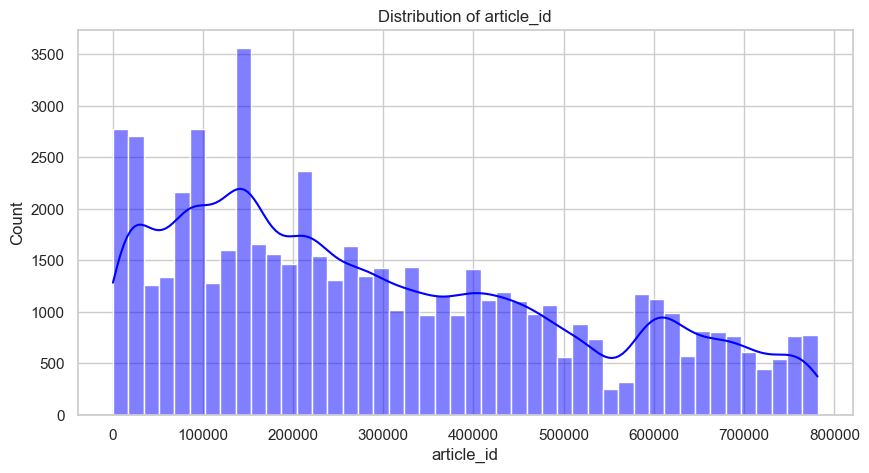

article_id - Mean: 298958.73449174035, Median: 251651.0, Std Dev: 216023.47756891217



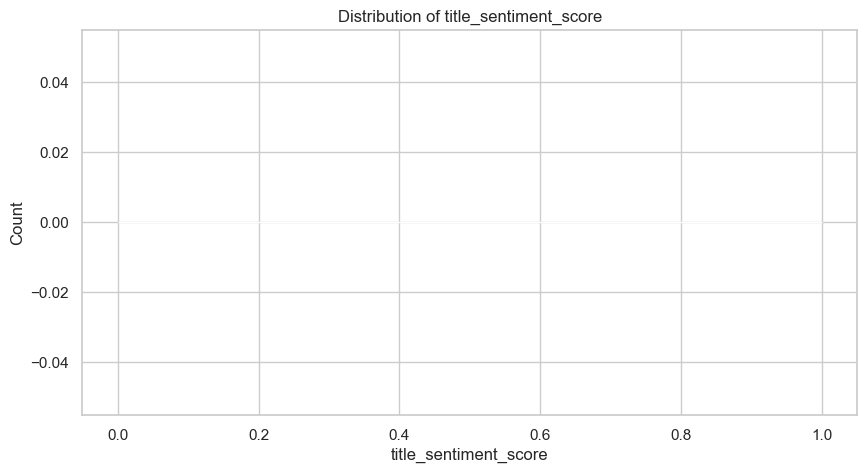

title_sentiment_score - Mean: nan, Median: nan, Std Dev: nan



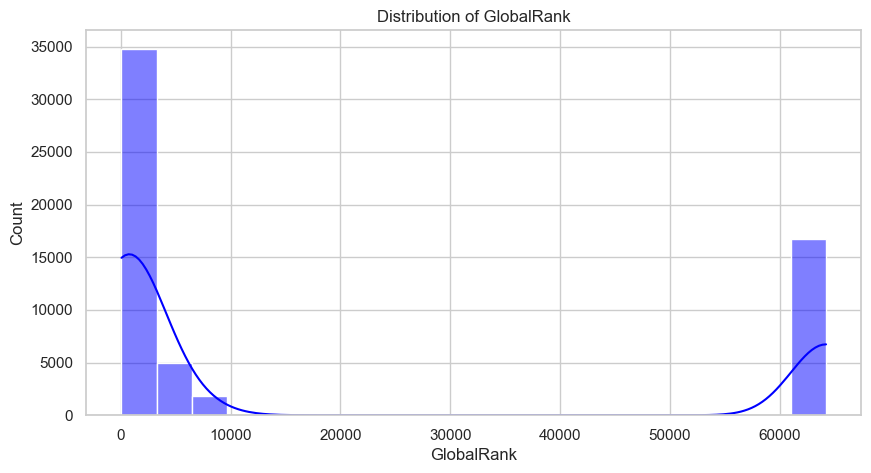

GlobalRank - Mean: 19207.386147097128, Median: 711.0, Std Dev: 28582.132571486392



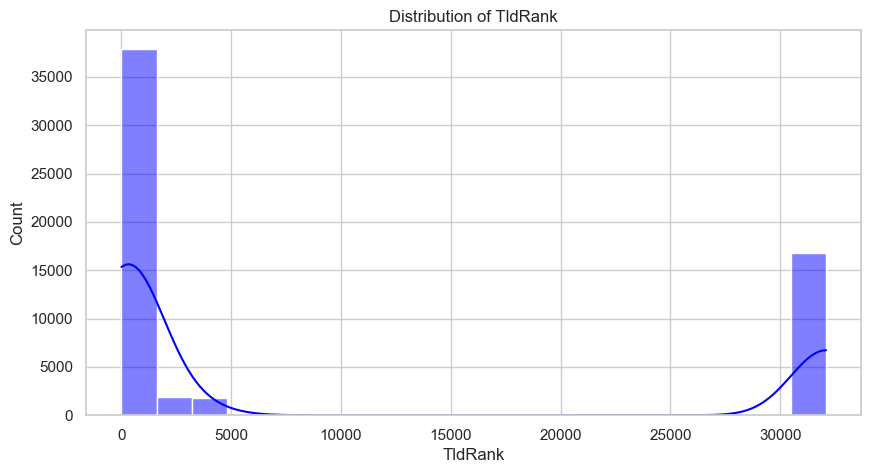

TldRank - Mean: 9539.972273630818, Median: 351.0, Std Dev: 14316.825996171454



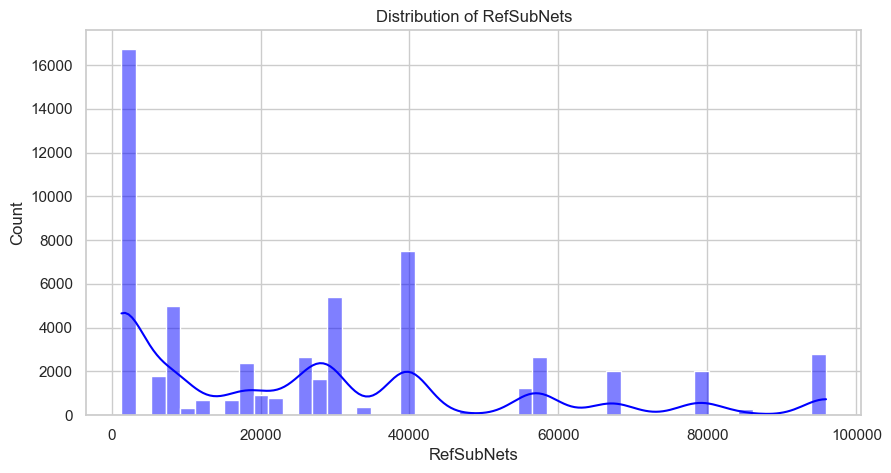

RefSubNets - Mean: 27210.862310645007, Median: 23010.0, Std Dev: 26858.717807533492



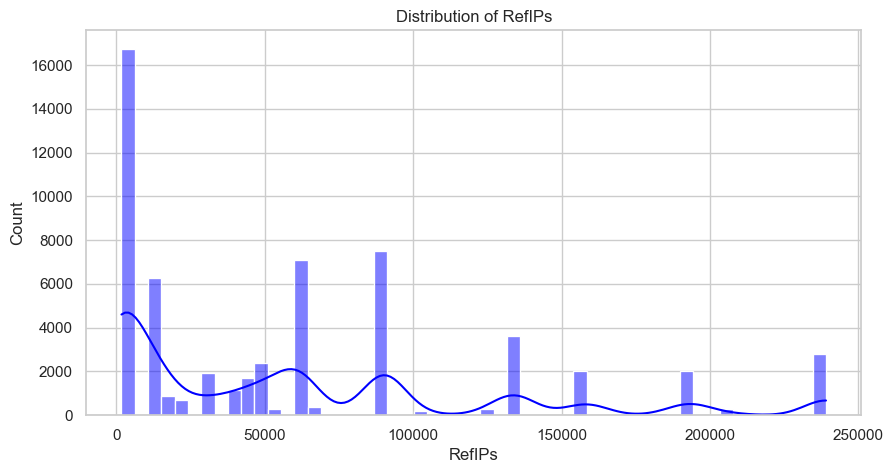

RefIPs - Mean: 61423.57257180067, Median: 46203.0, Std Dev: 66299.52321661075



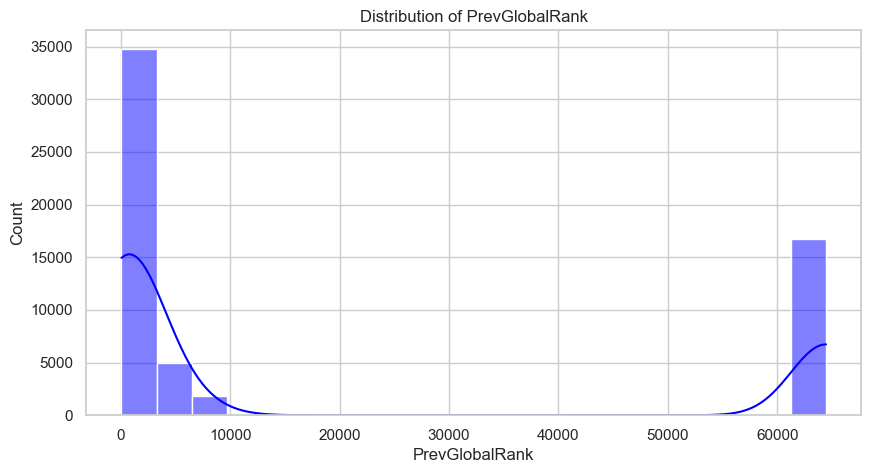

PrevGlobalRank - Mean: 19283.032987182123, Median: 716.0, Std Dev: 28695.339077509514



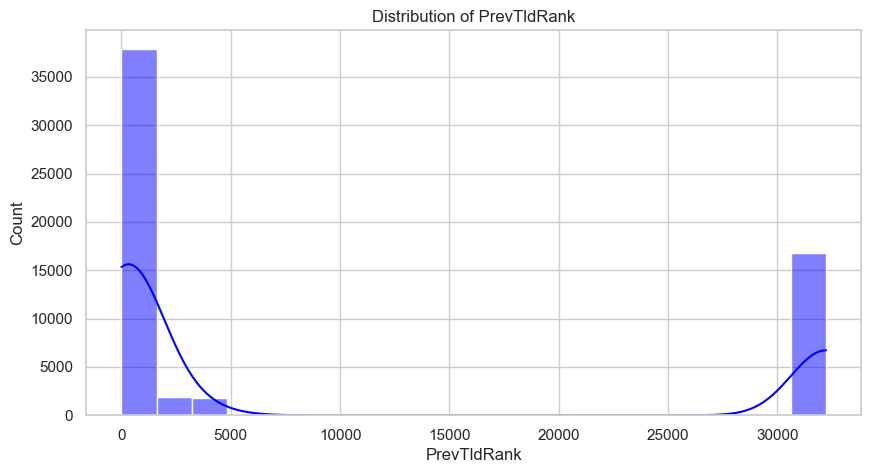

PrevTldRank - Mean: 9581.88840907533, Median: 357.0, Std Dev: 14379.64840079515



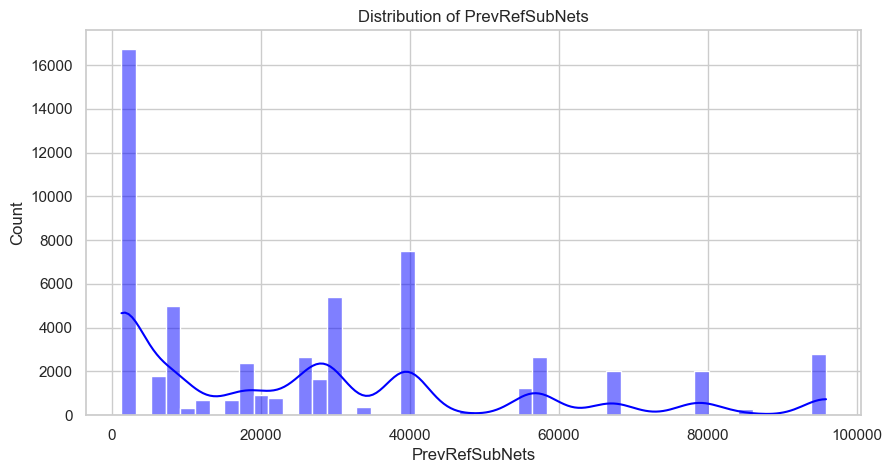

PrevRefSubNets - Mean: 27157.99035232024, Median: 22903.0, Std Dev: 26834.336326419812



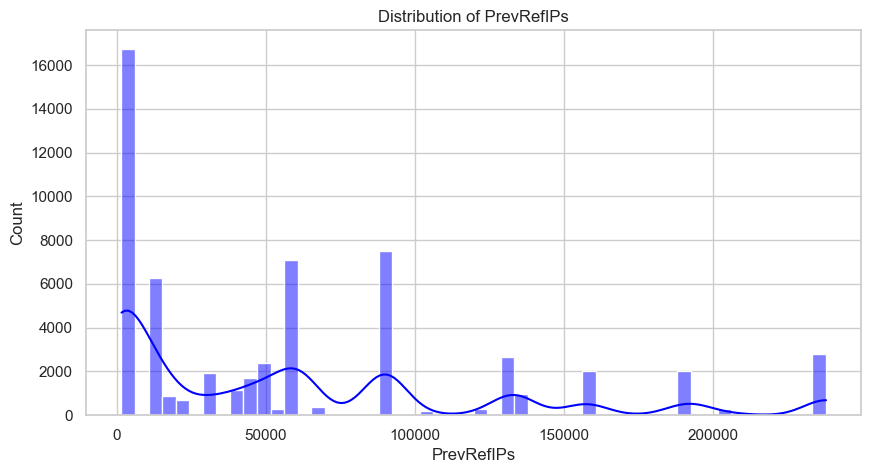

PrevRefIPs - Mean: 61138.376413736376, Median: 45946.0, Std Dev: 65962.55993398839



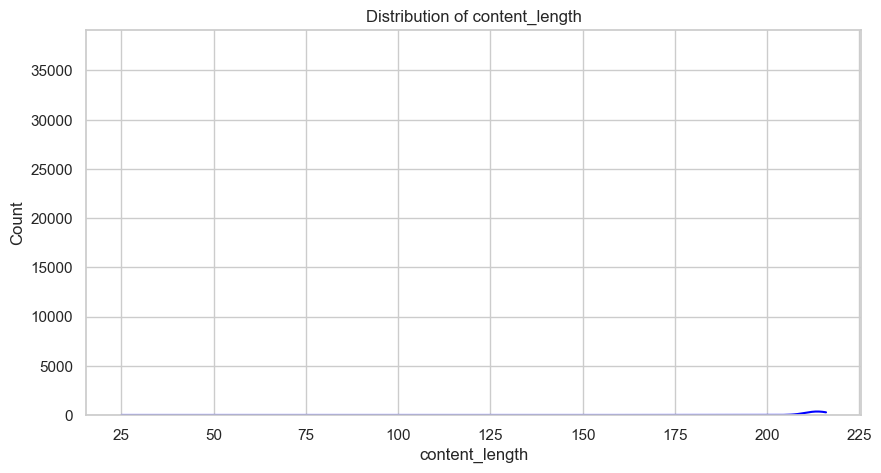

content_length - Mean: 207.8389197340462, Median: 214.0, Std Dev: 28.56668248540557



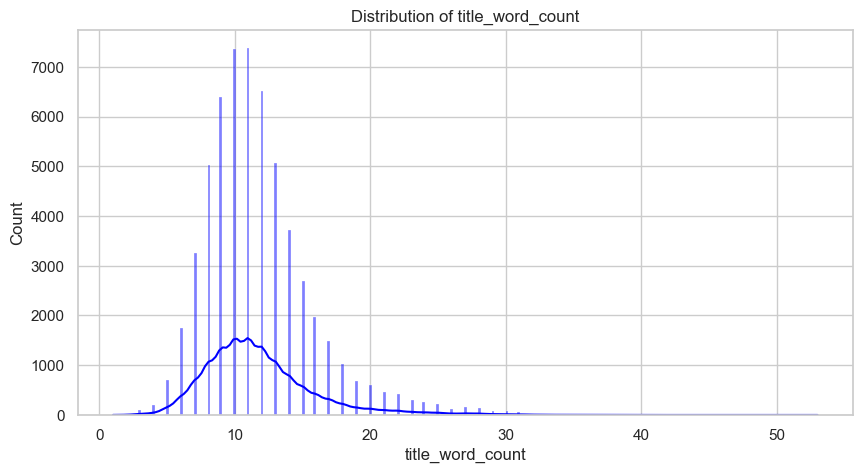

title_word_count - Mean: 11.753375831105627, Median: 11.0, Std Dev: 4.139166327049792



In [144]:
# Function to plot histograms and display descriptive statistics
def plot_histograms(df):
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for column in numerical_columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df[column], kde=True, color='blue')
        plt.title(f'Distribution of {column}')
        plt.show()

        # Descriptive statistics
        mean = df[column].mean()
        median = df[column].median()
        std_dev = df[column].std()
        print(f"{column} - Mean: {mean}, Median: {median}, Std Dev: {std_dev}\n")

plot_histograms(final_df)


In [145]:
# Function to plot bar charts for categorical data and display value counts
#def plot_bar_charts(df):
    #categorical_columns = df.select_dtypes(include=['object']).columns
    #for column in categorical_columns:
        #plt.figure(figsize=(10, 5))
        #df[column].value_counts().plot(kind='bar', color='green')
        #plt.title(f'Bar Chart of {column}')
        #plt.show()

        # Display value counts
        #print(f"Value Counts for {column}:")
        #print(df[column].value_counts(), "\n")

#plot_bar_charts(final_df)


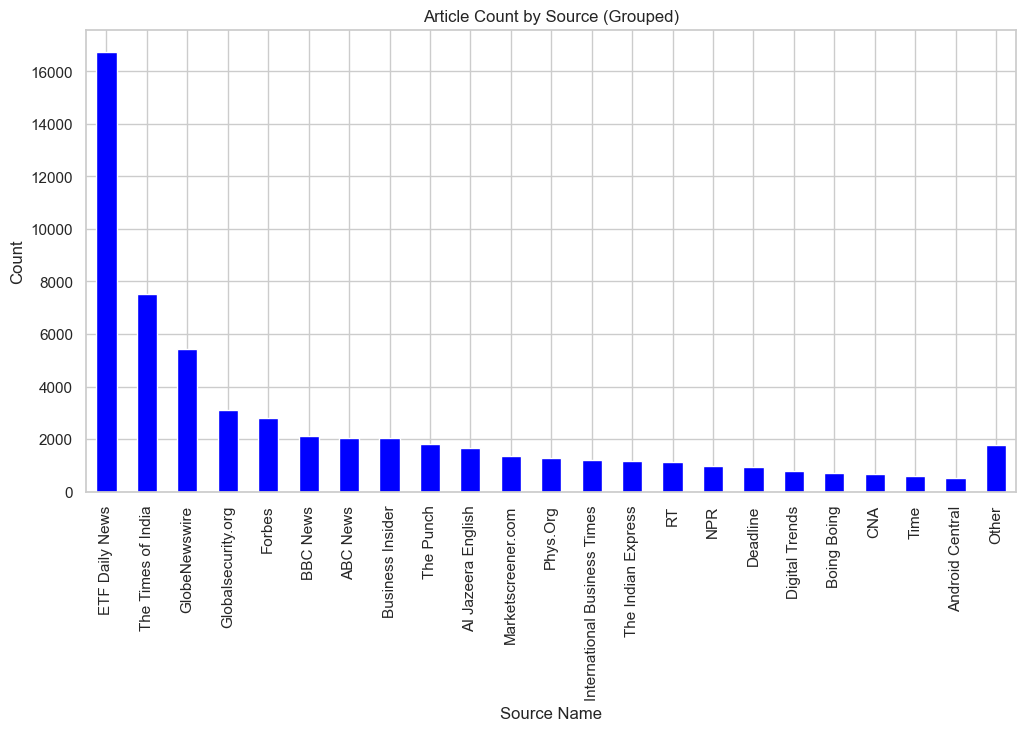

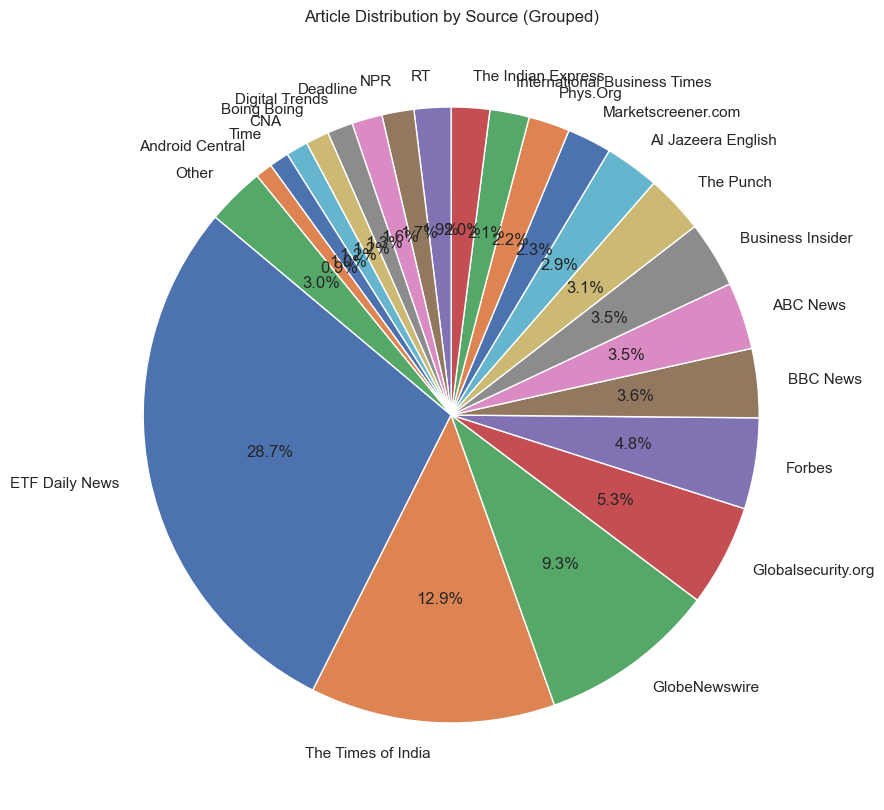

In [146]:
# Group sources with less than a threshold into 'Other'
threshold = 500
source_counts = final_df['source_name'].value_counts()
grouped_sources = source_counts[source_counts >= threshold]
grouped_sources['Other'] = source_counts[source_counts < threshold].sum()

# Plot the grouped sources as a bar chart
plt.figure(figsize=(12, 6))
grouped_sources.plot(kind='bar', color='blue')
plt.title('Article Count by Source (Grouped)')
plt.xlabel('Source Name')
plt.ylabel('Count')
plt.show()

# Plot the same data as a pie chart
plt.figure(figsize=(10, 10))
grouped_sources.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Article Distribution by Source (Grouped)')
plt.ylabel('')  # Hide the y-label for a cleaner pie chart
plt.show()


In [147]:
# Calculate the percentage contribution of each source
percentage_contribution = (source_counts / len(final_df)) * 100
print(percentage_contribution)

source_name
ETF Daily News                  28.696278
The Times of India              12.859003
GlobeNewswire                    9.292960
Globalsecurity.org               5.344780
Forbes                           4.770718
BBC News                         3.620879
ABC News                         3.526630
Business Insider                 3.485503
The Punch                        3.084516
Al Jazeera English               2.851463
Marketscreener.com               2.333950
Phys.Org                         2.164302
International Business Times     2.068339
The Indian Express               2.015217
RT                               1.932963
NPR                              1.681061
Deadline                         1.597094
Digital Trends                   1.343478
Boing Boing                      1.221811
CNA                              1.154980
Time                             1.028172
Android Central                  0.894510
Gizmodo.com                      0.664885
ReadWrite             

Exploratory Data Analysis

1.1 Top and Bottom 10 Websites by News Articles Count

In [148]:
# Top 10 websites with the largest count of news articles
top_10_websites = final_df['source_name'].value_counts().head(10)
print("Top 10 Websites by Article Count:\n", top_10_websites)

# Bottom 10 websites with the smallest count of news articles
bottom_10_websites = final_df['source_name'].value_counts().tail(10)
print("\nBottom 10 Websites by Article Count:\n", bottom_10_websites)


Top 10 Websites by Article Count:
 source_name
ETF Daily News        16746
The Times of India     7504
GlobeNewswire          5423
Globalsecurity.org     3119
Forbes                 2784
BBC News               2113
ABC News               2058
Business Insider       2034
The Punch              1800
Al Jazeera English     1664
Name: count, dtype: int64

Bottom 10 Websites by Article Count:
 source_name
CNA                            674
Time                           600
Android Central                522
Gizmodo.com                    388
ReadWrite                      324
Euronews                       286
Wired                          270
CNN                            267
The Verge                      214
AllAfrica - Top Africa News     20
Name: count, dtype: int64


1.2 Top and Bottom 10 Websites by Visitor Traffic

In [149]:
# Define estimated visitors
def estimate_visitors(row):
    # Extract relevant columns
    global_rank = row['GlobalRank']
    ref_subnets = row['RefSubNets']
    ref_ips = row['RefIPs']
    
    # Handle potential division by zero or missing values
    if global_rank <= 0:  # GlobalRank should be a positive integer
        return None
    if pd.isna(ref_subnets) or pd.isna(ref_ips):
        return None

    # Example scaling factor
    scaling_factor = 10000
    
    # Calculate estimated visitors
    estimated_visitors = (1 / global_rank) * (ref_subnets + ref_ips) * scaling_factor
    return estimated_visitors

# Apply the function to the DataFrame
final_df['EstimatedVisitors'] = final_df.apply(estimate_visitors, axis=1)

# Display the first few rows of the updated DataFrame
print(final_df[['Domain', 'GlobalRank', 'RefSubNets', 'RefIPs', 'EstimatedVisitors']].head())


                Domain  GlobalRank  RefSubNets  RefIPs  EstimatedVisitors
0           forbes.com          64       95914  239145       5.235297e+07
1  channelnewsasia.com        1755       13144   23964       2.114416e+05
2             time.com         137       58079  133712       1.399934e+07
3             phys.org         616       25240   49640       1.215584e+06
4    digitaltrends.com         711       23010   46203       9.734599e+05


In [150]:
# Top 10 websites by visitor traffic
top_10_traffic_websites = final_df[['source_name', 'EstimatedVisitors']].groupby('source_name').mean().sort_values(by='EstimatedVisitors', ascending=False).head(10)
print("Top 10 Websites by Visitor Traffic:\n", top_10_traffic_websites)

# Bottom 10 websites by visitor traffic
bottom_10_traffic_websites = final_df[['source_name', 'EstimatedVisitors']].groupby('source_name').mean().sort_values(by='EstimatedVisitors').head(10)
print("\nBottom 10 Websites by Visitor Traffic:\n", bottom_10_traffic_websites)


Top 10 Websites by Visitor Traffic:
                     EstimatedVisitors
source_name                          
Forbes                   5.235297e+07
CNN                      3.728397e+07
BBC News                 3.117612e+07
Business Insider         1.960565e+07
Time                     1.399934e+07
ABC News                 1.335385e+07
NPR                      1.298639e+07
Wired                    1.218676e+07
The Verge                7.441040e+06
The Times of India       4.478483e+06

Bottom 10 Websites by Visitor Traffic:
                               EstimatedVisitors
source_name                                    
ETF Daily News                       471.103082
The Punch                          25162.861492
Marketscreener.com                 54705.732484
Globalsecurity.org                 60780.501550
Android Central                    73611.851852
AllAfrica - Top Africa News        98448.660714
ReadWrite                         115247.967480
CNA                               

1.3 Countries with the Highest Number of News Media Organizations

In [151]:
# Count of news media organizations (domains) by country
country_media_count = final_df['location'].value_counts()
top_countries_media = country_media_count.head(10)
print("Countries with the Highest Number of News Media Organizations:\n", top_countries_media)


Countries with the Highest Number of News Media Organizations:
 location
US         42929
IN          8680
UK          2113
NI          1820
Unknown     1686
RS          1128
Name: count, dtype: int64


1.4 Countries with Many Articles Written About Them

In [152]:
# Grouping by location to find out the number of articles related to each country
articles_about_countries = final_df['location'].value_counts()
print("Countries with Many Articles Written About Them:\n", articles_about_countries.head(10))


Countries with Many Articles Written About Them:
 location
US         42929
IN          8680
UK          2113
NI          1820
Unknown     1686
RS          1128
Name: count, dtype: int64


1.5 Websites Reporting About Specific Regions

In [153]:
# Extract unique country names or codes
unique_countries = final_df['Country'].dropna().unique()

# Convert to a DataFrame for better visualization (optional)
unique_countries_df = pd.DataFrame(unique_countries, columns=['Country'])

# Display the unique country names or codes
print(unique_countries_df)

          Country
0   United States
1  United Kingdom
2          Russia
3         Nigeria
4           India
5         Unknown


In [154]:
# Updated regions dictionary with new countries
regions = {
    'North America': ['United States'],
    'Europe': ['United Kingdom', 'Russia'],  # Including Russia here for a broader European context
    'Asia': ['India'],
    'Africa': ['Nigeria'],
    'Middle East': ['Saudi Arabia', 'UAE', 'Iran', 'Israel', 'Turkey'],
    'South America': ['Brazil', 'Argentina', 'Chile'],
    'Oceania': ['Australia', 'New Zealand'],
    'Other': []  # To include any additional or unspecified regions
}

# Function to categorize a website based on its location
def categorize_region(location):
    for region, countries in regions.items():
        if location in countries:
            return region
    return 'Other'

# Apply the function to categorize each entry
final_df['region'] = final_df['Country'].apply(categorize_region)

# Count of websites reporting about specific regions
region_report_counts = final_df['region'].value_counts()
print("Websites Reporting About Specific Regions:\n", region_report_counts)


Websites Reporting About Specific Regions:
 region
North America    42929
Asia              8680
Europe            3241
Africa            1820
Other             1686
Name: count, dtype: int64


1.6 Websites with Highest Count of Positive, Neutral, and Negative Sentiment

In [155]:
# Assuming sentiment column exists with values 'positive', 'neutral', 'negative'
sentiment_summary = final_df.groupby('source_name')['title_sentiment'].value_counts().unstack().fillna(0)

# Descriptive statistics for sentiment
sentiment_stats = sentiment_summary.describe()
print("Descriptive Statistics for Sentiments:\n", sentiment_stats)


Descriptive Statistics for Sentiments:
 title_sentiment     Negative       Neutral     Positive
count              29.000000     29.000000    29.000000
mean              314.931034   1480.206897   217.137931
std               322.229835   2894.099655   306.381616
min                 8.000000     12.000000     0.000000
25%                65.000000    253.000000    54.000000
50%               216.000000    787.000000    86.000000
75%               455.000000   1185.000000   170.000000
max              1210.000000  15194.000000  1145.000000


1.7 Compare Impact of Mean and Median Sentiment

In [163]:
# Group by 'source_name' and calculate sentiment counts
sentiment_counts = final_df.groupby('source_name')['title_sentiment'].value_counts().unstack().fillna(0)

# Rename columns for clarity
sentiment_counts.columns = ['negative_count', 'neutral_count', 'positive_count']

# Get the top websites for each sentiment type
top_positive_websites = sentiment_counts[['positive_count']].nlargest(10, 'positive_count')
top_neutral_websites = sentiment_counts[['neutral_count']].nlargest(10, 'neutral_count')
top_negative_websites = sentiment_counts[['negative_count']].nlargest(10, 'negative_count')

print("Top Websites by Positive Sentiment Count:\n", top_positive_websites)
print("\nTop Websites by Neutral Sentiment Count:\n", top_neutral_websites)
print("\nTop Websites by Negative Sentiment Count:\n", top_negative_websites)


Top Websites by Positive Sentiment Count:
                     positive_count
source_name                       
The Times of India          1145.0
ETF Daily News               992.0
GlobeNewswire                905.0
Forbes                       635.0
Digital Trends               406.0
Android Central              272.0
Business Insider             237.0
Boing Boing                  170.0
Marketscreener.com           153.0
Phys.Org                     143.0

Top Websites by Neutral Sentiment Count:
                     neutral_count
source_name                      
ETF Daily News            15194.0
The Times of India         5149.0
GlobeNewswire              4491.0
Globalsecurity.org         2255.0
Forbes                     1933.0
The Punch                  1229.0
ABC News                   1193.0
BBC News                   1185.0
Marketscreener.com         1167.0
Al Jazeera English          927.0

Top Websites by Negative Sentiment Count:
                               negative_cou

Sentiment Summary for Top 10 Domains:
 title_sentiment       Negative       Neutral       Positive
mean                455.400000  1.613700e+03     334.300000
median              247.500000  1.046000e+03     112.000000
var              179197.822222  3.177049e+06  167778.677778


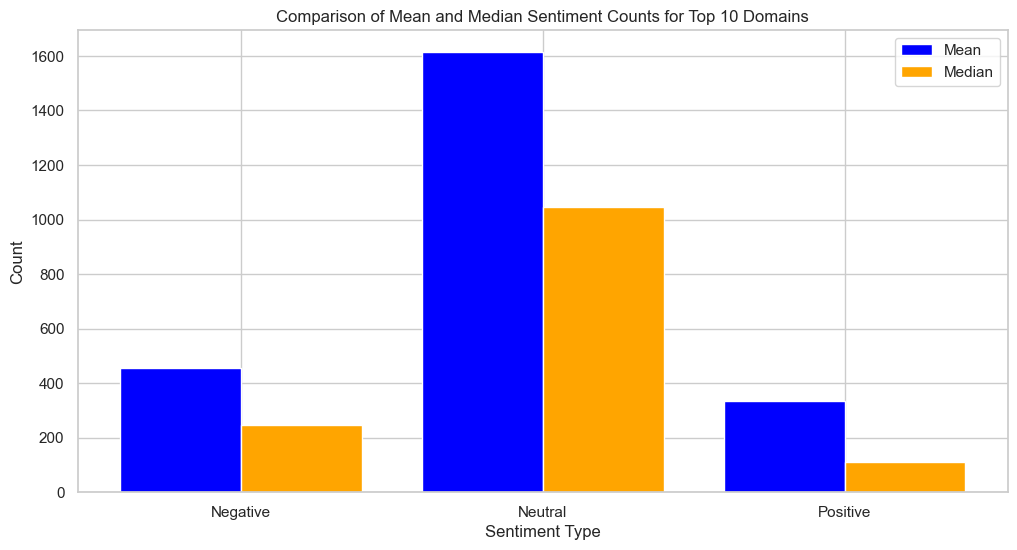

In [165]:
# Select top 10 domains by visitor traffic
top_10_domains = final_df.groupby('source_name')['EstimatedVisitors'].sum().nlargest(10).index

# Filter data for top 10 domains
top_10_df = final_df[final_df['source_name'].isin(top_10_domains)]

# Calculate sentiment counts for top 10 domains
sentiment_counts_top_10 = top_10_df.groupby('source_name')['title_sentiment'].value_counts().unstack().fillna(0)

# Calculate mean and median for each sentiment
sentiment_summary = sentiment_counts_top_10.agg(['mean', 'median', 'var'])

print("Sentiment Summary for Top 10 Domains:\n", sentiment_summary)

# Plot comparison of mean and median
# Data for plotting
sentiment_types = ['Negative', 'Neutral', 'Positive']
mean_values = [455.4, 1613.7, 334.3]
median_values = [247.5, 1046.0, 112.0]

# Create a bar plot for mean and median sentiment counts
x = range(len(sentiment_types))  # Position of bars

plt.figure(figsize=(12, 6))
plt.bar(x, mean_values, width=0.4, label='Mean', color='blue', align='center')
plt.bar([p + 0.4 for p in x], median_values, width=0.4, label='Median', color='orange', align='center')

plt.xlabel('Sentiment Type')
plt.ylabel('Count')
plt.title('Comparison of Mean and Median Sentiment Counts for Top 10 Domains')
plt.xticks([p + 0.2 for p in x], sentiment_types)
plt.legend()
plt.show()

1.8 Distribution of Sentiments for Top 10 Domains

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


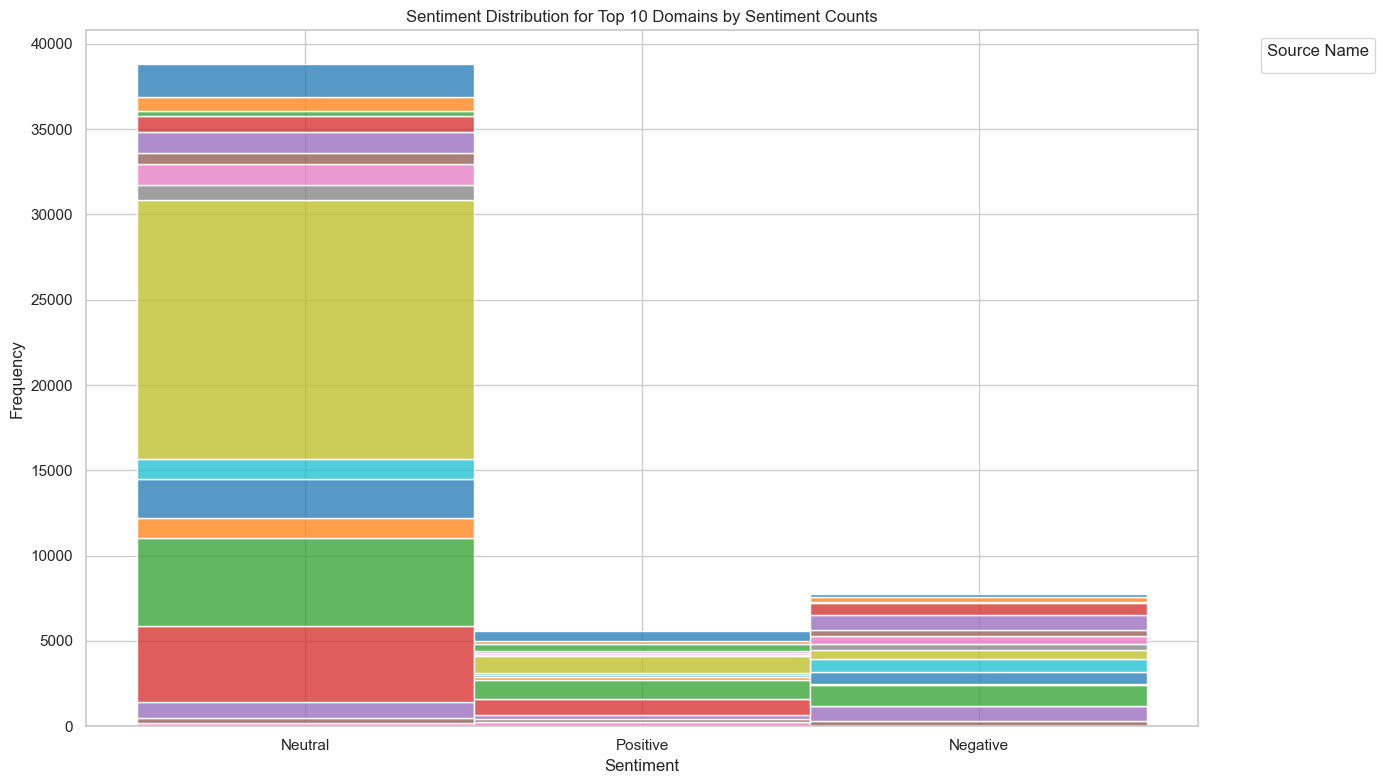

In [167]:
# Get the top websites for each sentiment type
top_positive_websites = sentiment_counts[['positive_count']].nlargest(10, 'positive_count').index
top_neutral_websites = sentiment_counts[['neutral_count']].nlargest(10, 'neutral_count').index
top_negative_websites = sentiment_counts[['negative_count']].nlargest(10, 'negative_count').index

# Combine all top domains into a single list
top_10_domains = set(top_positive_websites) | set(top_neutral_websites) | set(top_negative_websites)

# Filter data for top 10 domains
top_10_sentiments = final_df[final_df['source_name'].isin(top_10_domains)]

# Ensure that 'title_sentiment' is used correctly (assuming it's categorical)
if 'title_sentiment' not in top_10_sentiments.columns:
    raise ValueError("Column 'title_sentiment' not found in the data.")

# Plot sentiment distribution
plt.figure(figsize=(14, 8))
sns.histplot(data=top_10_sentiments, x='title_sentiment', hue='source_name', multiple='stack', bins=30, palette='tab10')

plt.title('Sentiment Distribution for Top 10 Domains by Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend(title='Source Name', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

2. Compare Content Metadata Across Sites
2.1 Distribution of Raw Message Lengths Across Sites

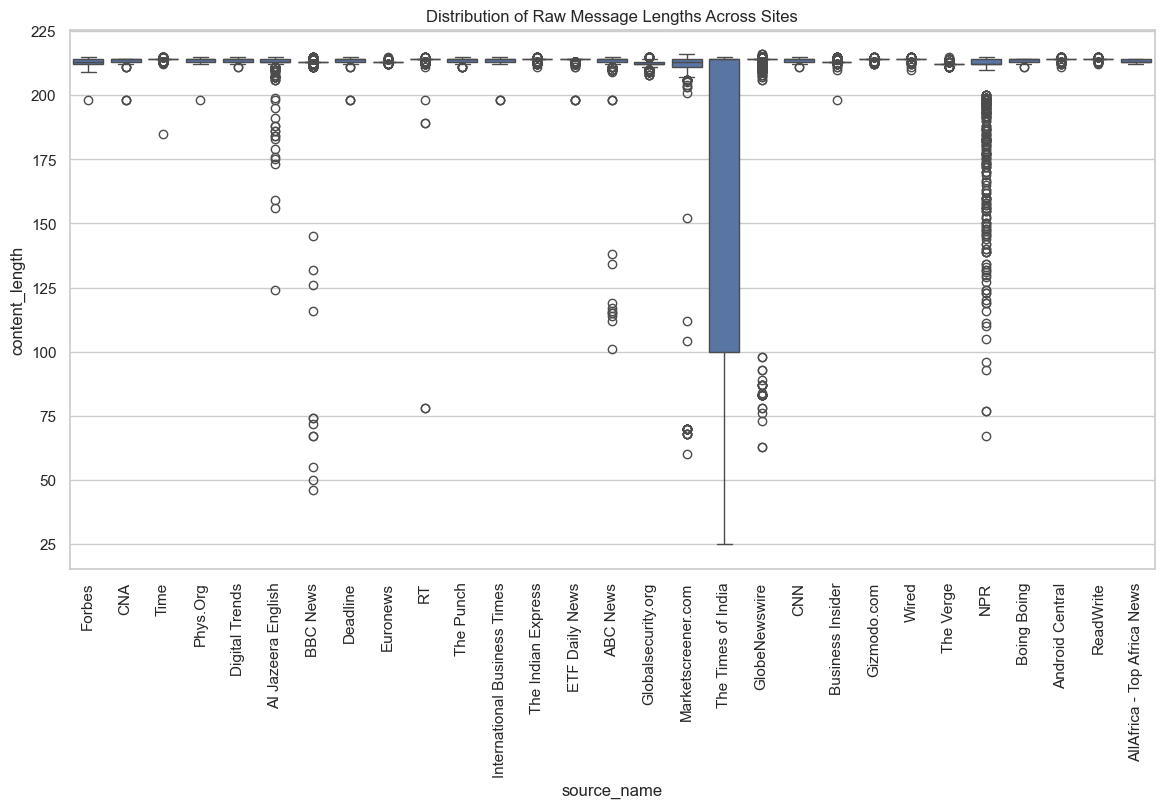

In [159]:
# Distribution of message lengths by site
plt.figure(figsize=(14, 7))
sns.boxplot(data=final_df, x='source_name', y='content_length')
plt.xticks(rotation=90)
plt.title('Distribution of Raw Message Lengths Across Sites')
plt.show()


2.2 Distribution of Title Word Counts Across Sites

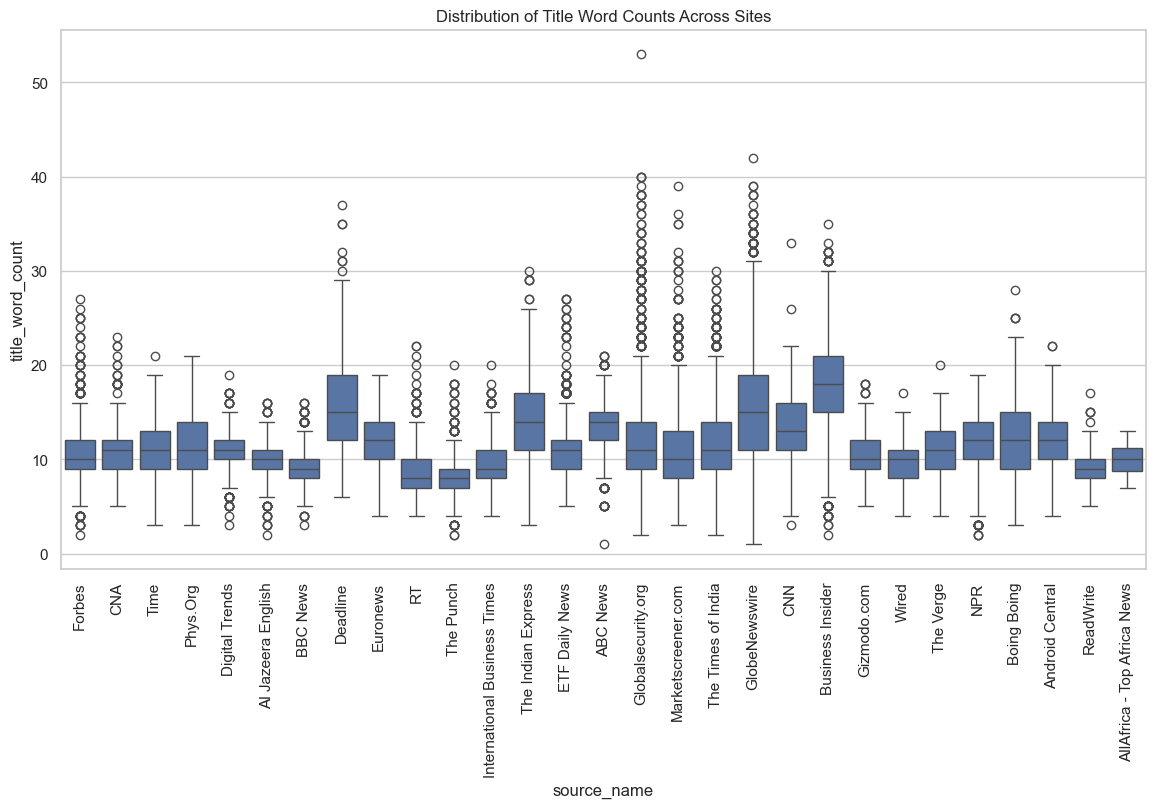

In [160]:
# Distribution of title word counts by site
plt.figure(figsize=(14, 7))
sns.boxplot(data=final_df, x='source_name', y='title_word_count')
plt.xticks(rotation=90)
plt.title('Distribution of Title Word Counts Across Sites')
plt.show()


3. Impact of Frequent Reporting and Sentiment on Global Ranking

In [161]:
# Scatter plot of number of reports vs. global ranking, colored by average sentiment
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_df, x='Reports', y='GlobalRank', hue='AverageSentiment', palette='coolwarm', size='Reports', sizes=(50, 200))
plt.title('Impact of Frequent Reporting and Sentiment on Global Ranking')
plt.xlabel('Total Number of Reports')
plt.ylabel('Global Ranking')
plt.show()


ValueError: Could not interpret value `Reports` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x800 with 0 Axes>